In [1]:
from langchain_openai import ChatOpenAI
from langchain_core.messages import HumanMessage, SystemMessage
from langchain_core.output_parsers import StrOutputParser
from langchain_core.prompts import ChatPromptTemplate
from langchain_core.pydantic_v1 import BaseModel, Field
import matplotlib.pyplot as plt
import random
import json
from dotenv import load_dotenv
import os
from tqdm import tqdm
import time
import networkx as nx
load_dotenv() 

/home/askatasuna/.cache/pypoetry/virtualenvs/dff-llm-integration-VcuUrJCU-py3.12/lib/python3.12/site-packages/IPython/core/interactiveshell.py:3577: LangChainDeprecationWarning: As of langchain-core 0.3.0, LangChain uses pydantic v2 internally. The langchain_core.pydantic_v1 module was a compatibility shim for pydantic v1, and should no longer be used. Please update the code to import from Pydantic directly.

For example, replace imports like: `from langchain_core.pydantic_v1 import BaseModel`
with: `from pydantic import BaseModel`
or the v1 compatibility namespace if you are working in a code base that has not been fully upgraded to pydantic 2 yet. 	from pydantic.v1 import BaseModel

  exec(code_obj, self.user_global_ns, self.user_ns)


True

Let's try to chain this thing

In [33]:
with open("prompts/prompt_v2.txt", 'r') as f:
    prompt = HumanMessage(f.read())

with open("prompts/prompt_augmentation.txt", 'r') as f:
    aug_prompt = f.read()

history = [prompt]

In [34]:
gen_model = ChatOpenAI(model="gpt-4o-mini", api_key=os.getenv("OPENAI_API_KEY"), base_url=os.getenv("OPENAI_BASE_URL"), temperature=0)
check_model = ChatOpenAI(model="gpt-4o-mini", api_key=os.getenv("OPENAI_API_KEY"), base_url=os.getenv("OPENAI_BASE_URL"), temperature=0)

check_triplet_prompt = ChatPromptTemplate.from_template("decide if the triplet is valid. triplet: {triplet}")
augmentation_prompt = ChatPromptTemplate.from_template(aug_prompt)


In [64]:
def generate_dialogue_graph_pair():
    response = gen_model.invoke(history)
    try:
        return json.loads(response.content)
    except json.JSONDecodeError:
        print("Error: Invalid JSON response. Retrying...")
        return None

In [65]:
results = []
for i in tqdm(range(10)):
    pair = None
    while pair is None:
        pair = generate_dialogue_graph_pair()
        if pair is not None:
            pair['id'] = i + 1
            results.append(pair)
        else:
            print("Invalid JSON.")
    time.sleep(1)  # Add a small delay between requests to avoid rate limiting

with open('dialogue_graph_pairs.json', 'w') as f:
    json.dump(results, f, indent=2)

print("Generation complete. Results saved to dialogue_graph_pairs.json")

100%|██████████| 10/10 [01:36<00:00,  9.66s/it]

Generation complete. Results saved to dialogue_graph_pairs.json


In [10]:
def visualize_graph(graph, title):
    G = nx.DiGraph()
    for node in graph["nodes"]:
        G.add_node(node["id"], label=node["label"])
    for edge in graph["edges"]:
        G.add_edge(edge["source"], edge["target"], label=edge["utterances"])

    pos = nx.spring_layout(G)
    nx.draw(G, pos, with_labels=True, node_color="lightblue", node_size=500, font_size=8, arrows=True)
    edge_labels = nx.get_edge_attributes(G, "label")
    nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels, font_size=6)
    plt.title(title)
    plt.axis("off")

In [2]:
with open('dialogue_graph_pairs.json', 'r') as f:
    graphs = json.load(f)

In [3]:
def dialogues_from_graph(graph, readable: bool=False):
    # Create a directed graph from the JSON input
    G = nx.DiGraph()
    
    # Add nodes and edges to the graph
    for node in graph['nodes']:
        # Ensure 'is_start' is included in the node attributes
        G.add_node(node['id'], label=node['label'], utterances=node['utterances'], is_start=node.get('is_start', False))
    
    for edge in graph['edges']:
        G.add_edge(edge['source'], edge['target'], utterances=edge['utterances'])
    
    # Start the dialogue from the starting node
    start_nodes = [node for node in G.nodes if G.nodes[node].get('is_start', True)]
    if not start_nodes:
        raise ValueError("No starting node found in the graph.")
    
    current_node = random.choice(start_nodes)  # Randomly select one of the starting nodes
    dialogue = []
    visited_nodes = set()  # Track visited nodes to prevent cycles
    
    # Generate a dialogue by traversing the graph
    while True:
        # Get the current node's utterances
        node_utterances = G.nodes[current_node]['utterances']
        # print("NODE:", node_utterances)
        dialogue.append(random.choice(node_utterances))  # Randomly select an utterance
        
        # Mark the current node as visited
        visited_nodes.add(current_node)
        
        # Get the next possible nodes to traverse
        next_nodes = list(G.successors(current_node))
        if not next_nodes:  # If there are no successors, break the loop
            break
        
        # Filter out already visited nodes to prevent cycles
        next_nodes = [node for node in next_nodes if node not in visited_nodes]
        if not next_nodes:  # If all next nodes have been visited, break the loop
            break
        
        next_node = random.choice(next_nodes)
        
        # Get the edge utterances between the current node and the next node
        edge_utterances = G[current_node][next_node]['utterances']
        # print("EDGE:", edge_utterances)
        dialogue.append(random.choice(edge_utterances)) 
        # Randomly select the next node to traverse
        current_node = next_node
    
    if readable:
        out = ""
        for i in range(len(dialogue)):
            if i % 2 == 0:
                out += f"ASSISTANT: {dialogue[i]}\n"
            else:
                out += f"USER: {dialogue[i]}\n"
        return out
    return dialogue

In [6]:
print(dialogues_from_graph(graphs[1], readable=True))

ASSISTANT: Welcome! What can I do for you?
USER: I want to book a flight.
ASSISTANT: Where would you like to fly to?
USER: I would like to fly from New York to London.
ASSISTANT: What time of day do you prefer to fly?
USER: I prefer a morning flight.
ASSISTANT: Would you like to try a different flight option?



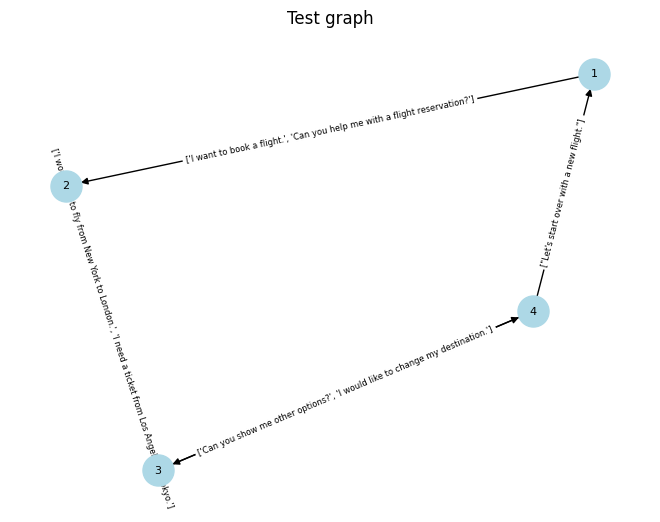

In [12]:
visualize_graph(graphs[1], "Test graph")


In [20]:
class Dialogue(BaseModel):
    sensibility: float = Field(description="Sensibility meter float from 0.0 to 1.0. If the dialogue make sense, logical and can be heard in speech between real people value is higher.")
    comment: str = Field(description="Commentary on why this score for the sensibility was made")

model = ChatOpenAI(model="gpt-4o-mini", api_key=os.getenv("OPENAI_API_KEY"), base_url=os.getenv("OPENAI_BASE_URL"), temperature=0)
check_model = model.with_structured_output(Dialogue)


In [23]:
scores = {}
for _, i in tqdm(enumerate(graphs)):
    dialogue = dialogues_from_graph(i, readable=True)
    res = await check_model.ainvoke(dialogue)
    scores[_] = {}
    scores[_]["dialogue"] = dialogue
    scores[_]["score"] = res.sensibility
    scores[_]["comment"] = res.comment

with open("scores.json", 'w') as f:
    f.write(json.dumps(scores, indent=2))

10it [00:26,  2.64s/it]


In [36]:
async def augment_data(graph: dict, themes: set, amount: int=5) -> list[dict]:
    res = []
    for theme in themes:
        for i in range(amount):
            result = await model.ainvoke(augmentation_prompt.format(THEME=theme, graph=graph))
            try:
                g = json.loads(result.content)
                res.append(g)
            except Exception:
                print("invalid graph")
    with open("augmented_graphs.json", 'w') as f:
        f.write(json.dumps(res, indent=2))

In [37]:
await augment_data(graphs[1], {"library", "camping", "cooking"})

In [ ]:
with open('augmented_graphs.json', 'r') as f:
    pass